## Cylindrical Transformation Approach
For each molecule, do:
$$
(x,y,z) \rightarrow (r,\varphi,z)
$$

### Setup of the Data

#### Initialization

In [1]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np
import cyltransf as ct # Made Functions
import time # For benchmarking

# Load data
t_set = 100

if t_set == 25:
    # 25 ns data
    file_dir = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-0308/results-0808"
elif t_set == 100:
    # 100 ns data
    file_dir = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-100ns-2008"

u = md.Universe(file_dir + "/md_1.tpr", file_dir + "/md_1_noPBC.xtc")
u.trajectory[-1]
prot = u.select_atoms("protein")
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

t_eq = 20000 # ps
# Time Data
ti = u.trajectory[0].time
tf = u.trajectory[-1].time
nt = len(u.trajectory)-1
deltat = (tf-ti)/nt
t = np.linspace(ti,tf,nt+1)
maskt = (t >= t_eq)

### One Molecule

In [73]:
mol = 32
molecule_mean = ct.get_centered_mean_coords_mol(u, prot, mol, maskt, "name CA")
molecule_mean_filt = ct.remove_ends(0.5, molecule_mean)
rad_mol, phi_mol, z_mol = ct.cyl_proj(molecule_mean_filt)
mol_length = z_mol.max() - z_mol.min()

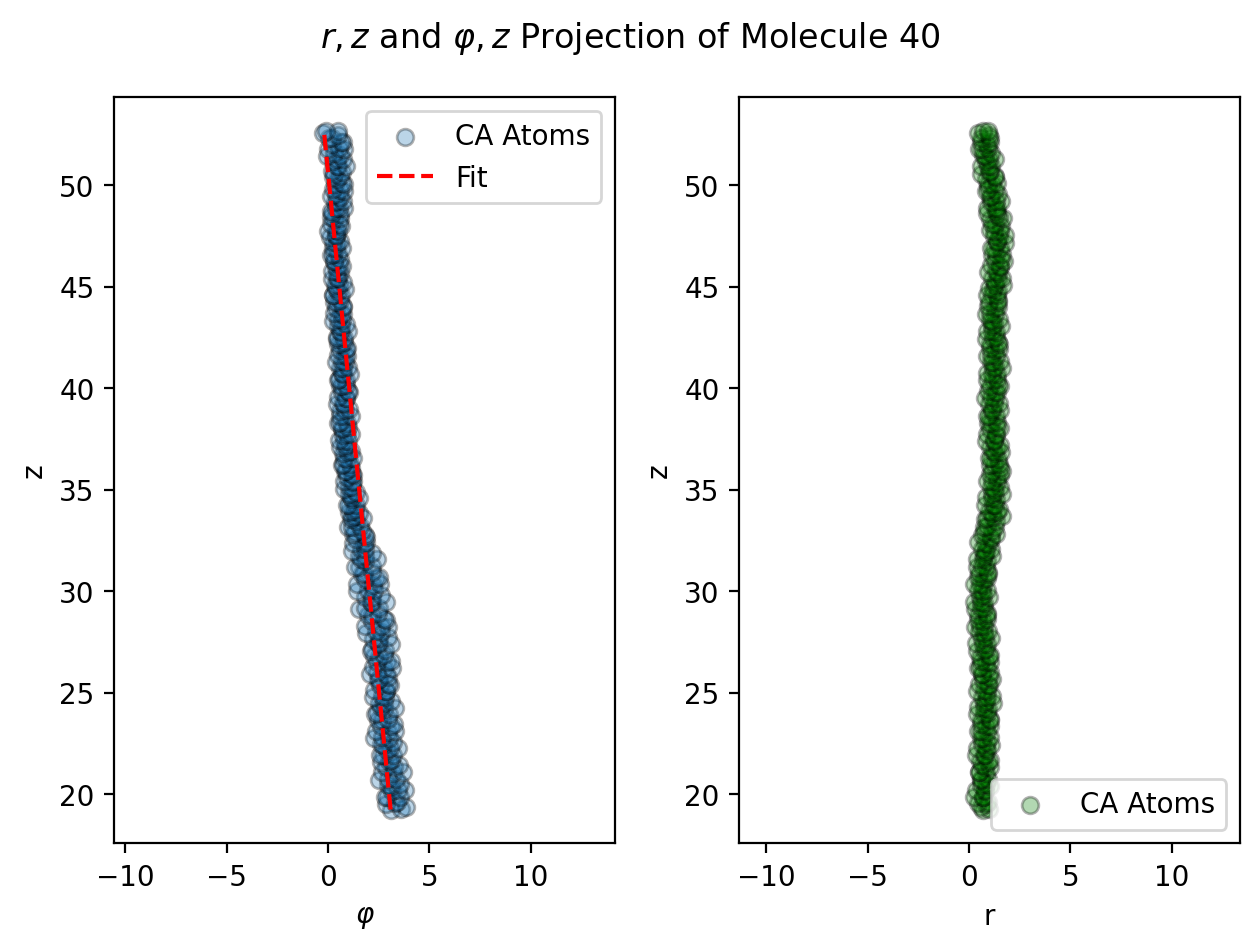

In [18]:
fig, ax = plt.subplots(1, 2, dpi=200)

ax[0].scatter(phi_mol, z_mol, alpha=0.3, edgecolor='k', label='CA Atoms')
m, b, r2filt = ct.linfitandr2(z_mol, phi_mol)
fit = np.poly1d((m, b))
ax[0].plot(fit(z_mol), z_mol, linestyle='dashed', color='r', label='Fit')

ax[0].axis('equal')
ax[0].set_xlabel(r'$\varphi$')
ax[0].set_ylabel(r'z')
ax[0].legend()

ax[1].scatter(rad_mol, z_mol, color='g', alpha=0.3, edgecolor='k', label='CA Atoms')
ax[1].axis('equal')
ax[1].set_xlabel(r'r')
ax[1].set_ylabel(r'z')
ax[1].legend()

plt.suptitle(rf'$r, z$ and $\varphi, z$ Projection of Molecule {mol}')
plt.tight_layout()
plt.show()

### Computation of $\tau(r), \psi(r)$ and associateds - Molecules

For this, we will implement this cutting of the ends, and then represent the radius as the mean, $\langle r \rangle$, to see if theres better improvement in the results we get.

In [ ]:
tot_mol = int((prot.fragindices[-1] + 1)/3)
tau = np.zeros(tot_mol)
r2s = np.zeros(tot_mol)
mean_rad = np.zeros(tot_mol)
length = np.zeros(tot_mol)
err_rad = np.zeros((2, tot_mol)) # Shape for errobars
std_rad = np.zeros(tot_mol)

for mol in range(tot_mol):
    # Mean
    molecule_mean = ct.get_centered_mean_coords_mol(u, prot, mol, maskt, "name CA")

    # Length of the Molecule
    length[mol] = molecule_mean[:,2].max() - molecule_mean[:,2].min()

    # Apply Filter
    molecule_mean_filt = ct.remove_ends(0.5, molecule_mean)

    # Cylindrical Coordinates
    rad, phi, z = ct.cyl_proj(molecule_mean_filt)

    # Fit and R2
    tau[mol], _, r2s[mol] = ct.linfitandr2(phi, z)

    # Radius Data
    mean_rad[mol] = np.mean(rad)
    err_rad[:, mol] = mean_rad[mol] - min(rad), max(rad) - mean_rad[mol] # Error (Difference) Lower and Higher
    std_rad[mol] = np.std(rad)

#### $R^2$ Filtering

In [31]:
filt_r2 = 0.95

# Psi - Angle with z axis
psi_rad = np.pi/2 - np.atan(abs(tau))
psi = np.rad2deg(psi_rad)

# Filter data
maskr2 = (r2s >= filt_r2)
tau_filt = tau[maskr2]
psi_filt = psi[maskr2]
mean_rad_filt = mean_rad[maskr2]
err_rad_filt = err_rad[:,maskr2]
std_rad_filt = std_rad[maskr2]
length_filt = length[maskr2]

Lets see if we can improve the data quality by filtering the "bad" fittings (one which have a jump). The most reasonable and straightforward method that comes to mind is by evaluating the linear fit (worse fit would correspond to jumps which cannot be correctly fitted).

### Visualization of the Results

#### $R^2$ Filtering

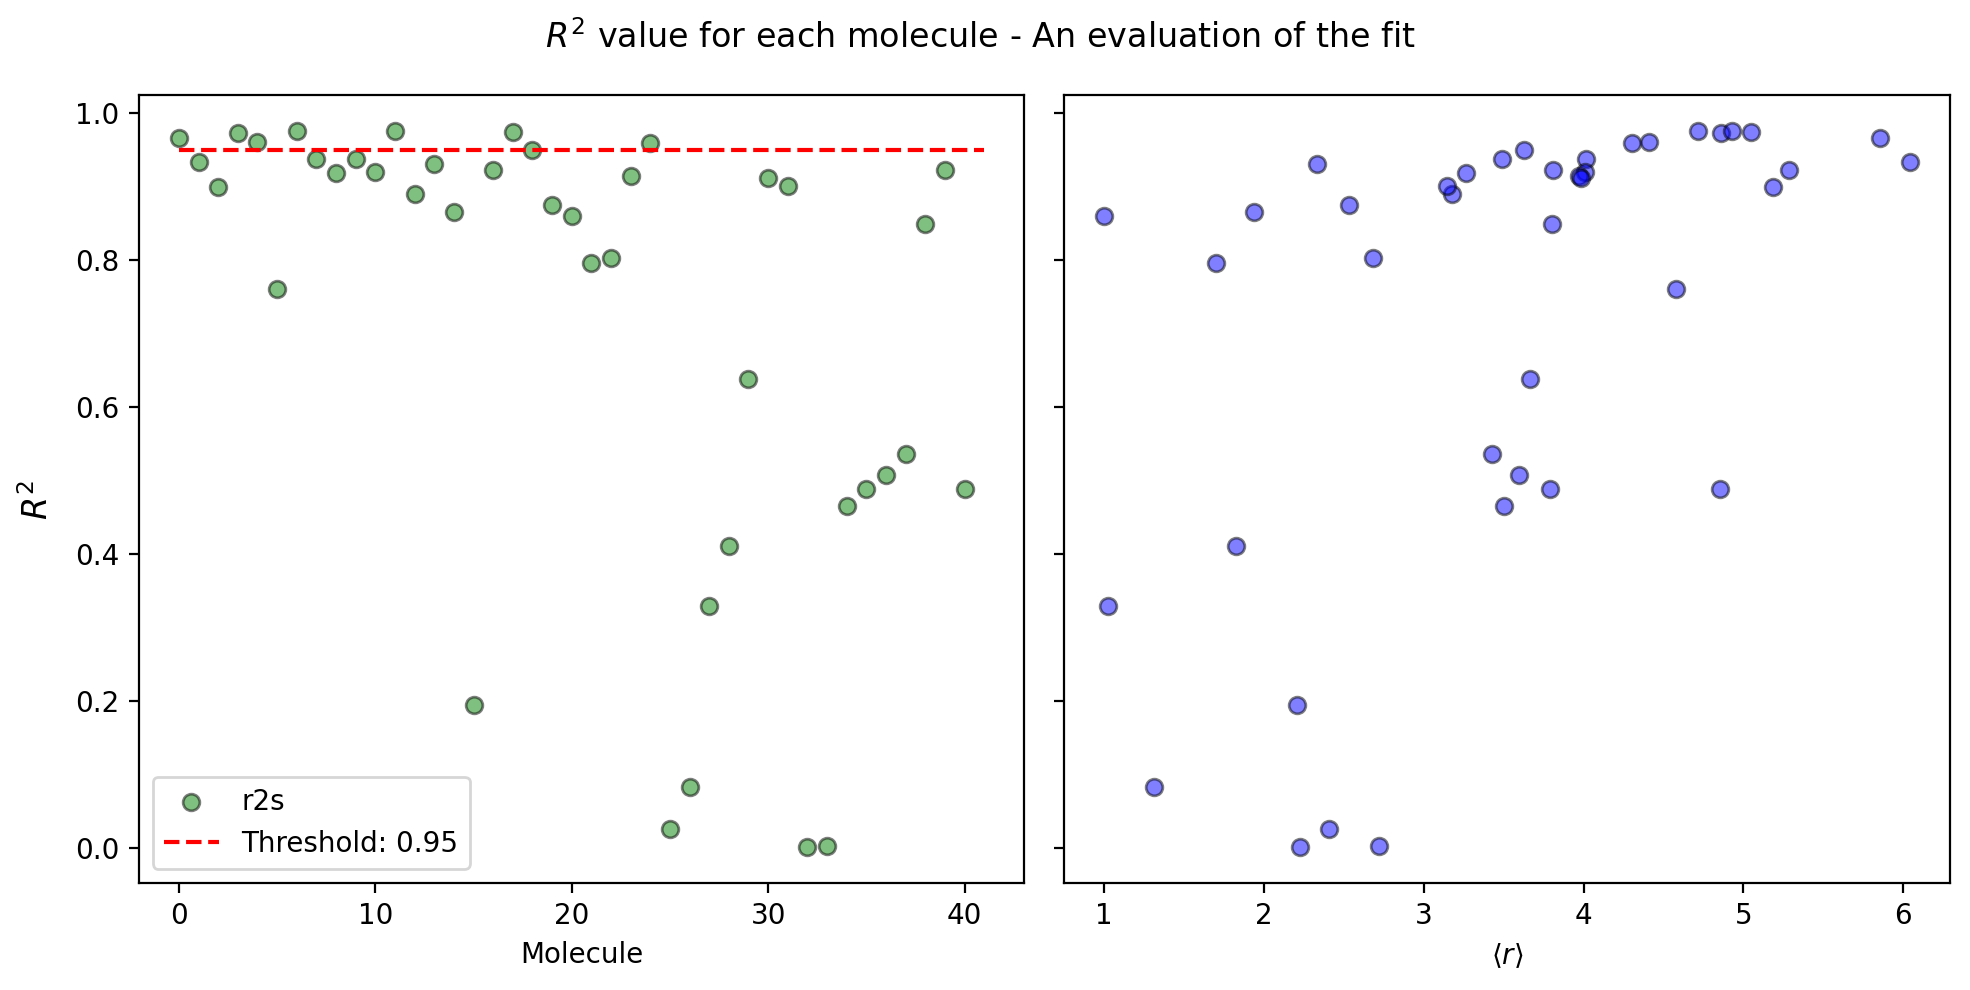

In [32]:
# Visualization of the Rsquared
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharey=True)
axs[0].scatter(np.arange(0, tot_mol), r2s, color='g', edgecolor='k', alpha=0.5, label='r2s')
axs[0].hlines(filt_r2, 0, tot_mol, color='r', linestyle='dashed', label=f'Threshold: {filt_r2}')
axs[0].set_xlabel(r'Molecule')
axs[0].legend()

axs[1].scatter(mean_rad, r2s, color='b', edgecolor='k', alpha=0.5)
axs[1].set_xlabel(r'$\langle r \rangle$')

fig.supylabel(r'$R^2$')
fig.suptitle(r"$R^2$ value for each molecule - An evaluation of the fit")

plt.tight_layout()
plt.show()

#### Plotting $\psi(r)$

The ACTUAL twist

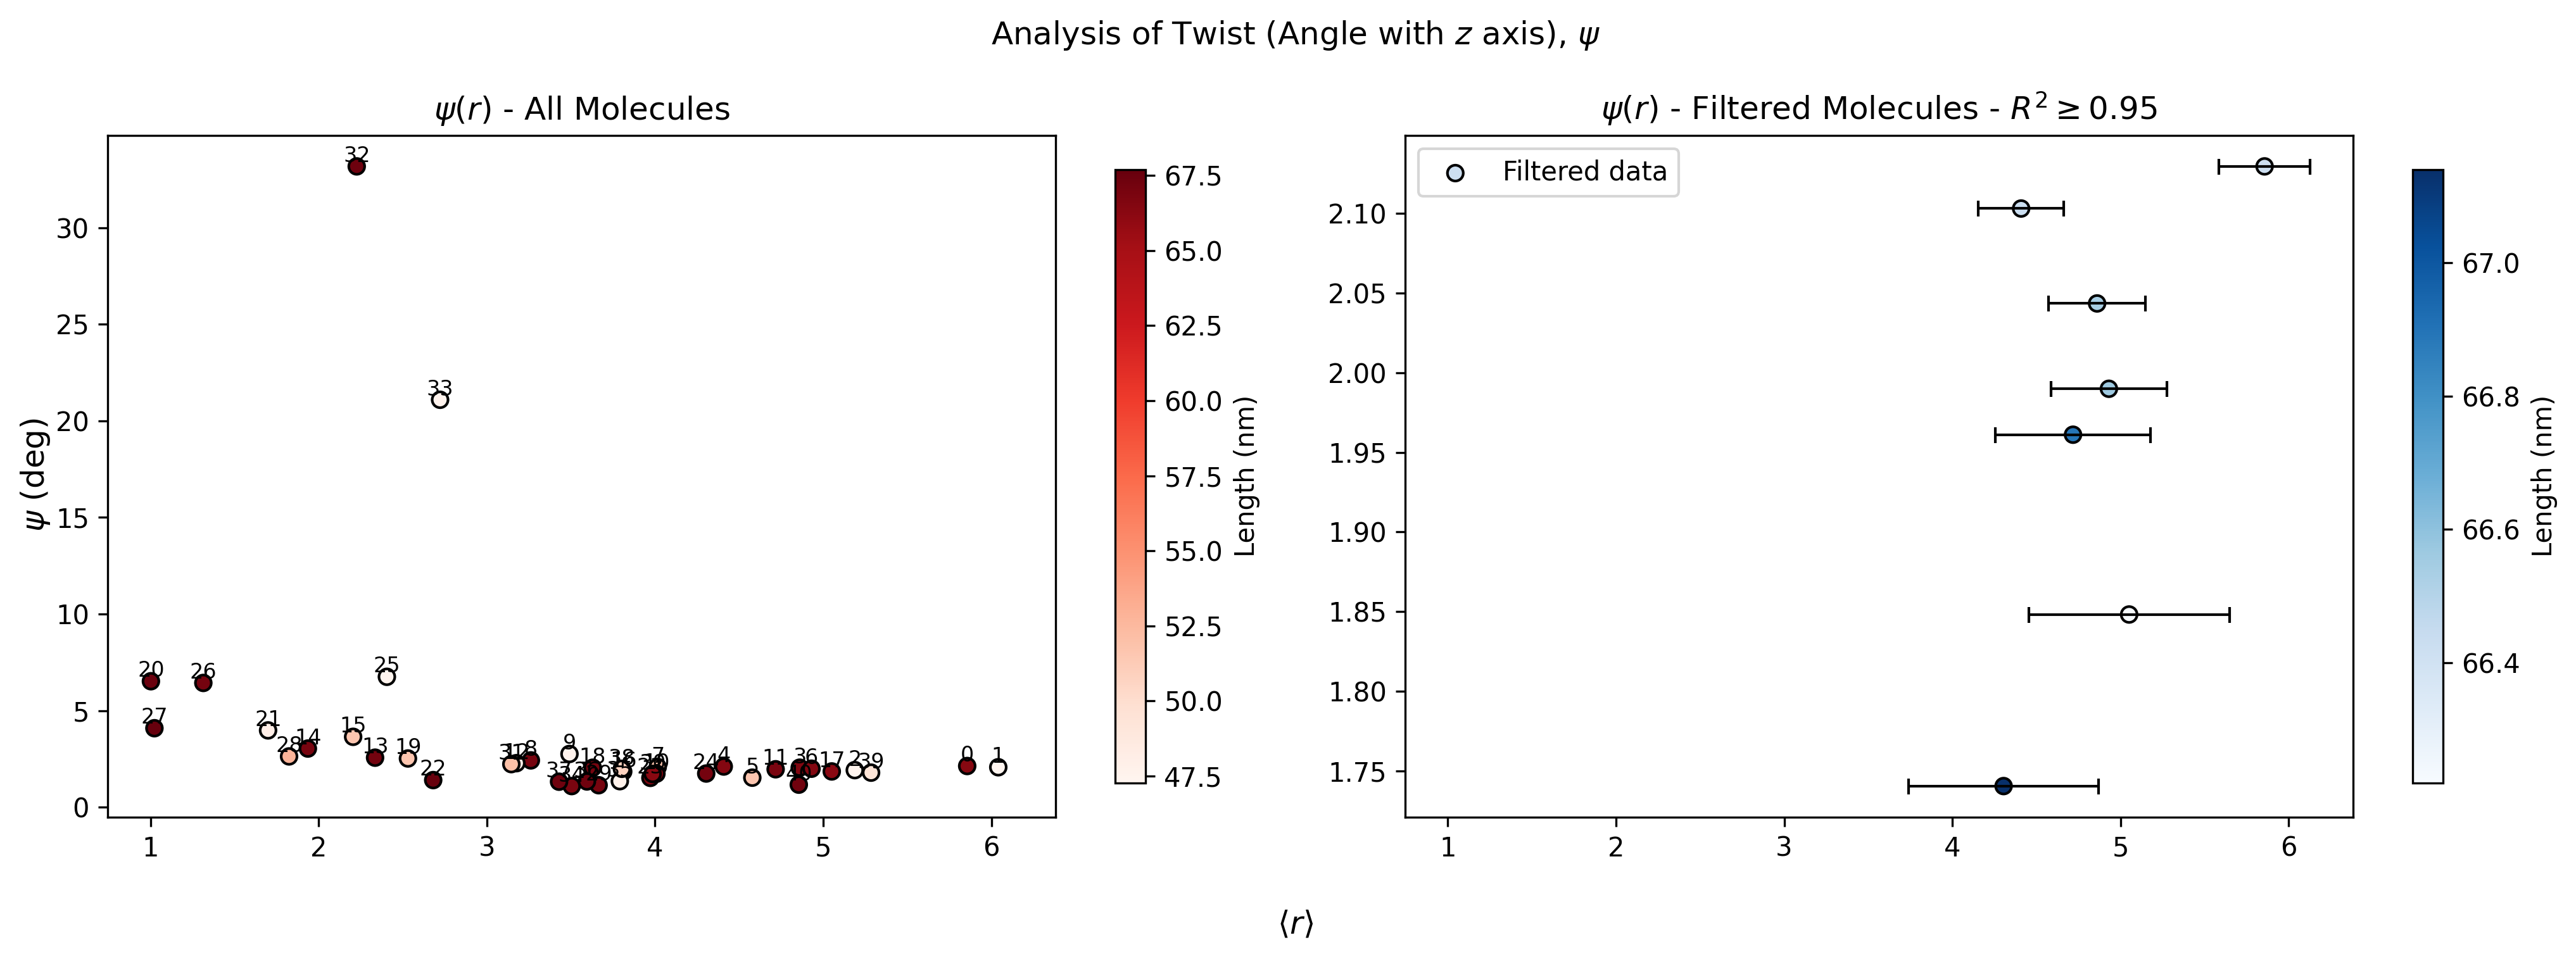

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), dpi=300, sharex=True)

# --- Left: original psi ---
sc0 = axs[0].scatter(mean_rad, psi, c=length, cmap = 'Reds', edgecolor='k')

for i, (x, y) in enumerate(zip(mean_rad, psi)):
    axs[0].text(x, y, str(i), fontsize=8, ha='center', va='bottom')

axs[0].set_title(r"$\psi(r)$ - All Molecules")

# --- Right: filtered psi ---
for xv, yv, xe in zip(mean_rad_filt, psi_filt, std_rad_filt):
    axs[1].errorbar(xv, yv, xerr=xe, fmt='none', color='black', elinewidth=1, capsize=3)
sc1 = axs[1].scatter(mean_rad_filt, psi_filt, c=length_filt, cmap = 'Blues', edgecolors='k', label='Filtered data')
axs[1].set_title(rf"$\psi(r)$ - Filtered Molecules - $R^2 \geq${filt_r2}")
axs[1].legend()

cbar0 = fig.colorbar(sc0, ax=axs[0], orientation='vertical', shrink=0.9)
cbar0.set_label("Length (nm)")

cbar1 = fig.colorbar(sc1, ax=axs[1], orientation='vertical', shrink=0.9)
cbar1.set_label("Length (nm)")

fig.suptitle(r'Analysis of Twist (Angle with $z$ axis), $\psi$')
fig.supylabel(r'$\psi$ (deg)')
fig.supxlabel(r'$\langle r \rangle$')
plt.tight_layout()
plt.show()
